# Project: Poisonous Mushrooms
## Dimensionality Reduction, Clustering, and Classification

_By Isa Chau for W207: Applied Machine Learning, UC Berkeley School of Information Master of Information and Data Science Program (MIDS), Fall 2019._

**This notebook is based on a project I completed for the MIDS program. In summary, we experiment with PCA, data visualization, and clustering in the pursuit of classifying poisonous mushrooms.**


In this project, we'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, we've binarized the feature space. Look at the feature_names below to see all 126 binary names.

We'll start by running PCA to reduce the dimensionality from 126 down to 2 so that we can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once we've projected the data to 2 dimensions, we'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, we'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [2]:
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from scipy.spatial.distance import cdist
import matplotlib.patches as mpatches

In [3]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [4]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))

Loaded feature names:  126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [5]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)
    
# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [6]:
def P1():
    #built in sklearn PCA
    pca = PCA()
    PC = pca.fit_transform(train_data)
    pc_variances =  pca.explained_variance_ratio_
    for k in range(0,50):
        print('Fraction of total variance explained by principal components 1 through {0:2}:   {1:.5}'.format(
            k+1, sum(pc_variances[0:k+1])))
P1()

Fraction of total variance explained by principal components 1 through  1:   0.16404
Fraction of total variance explained by principal components 1 through  2:   0.29728
Fraction of total variance explained by principal components 1 through  3:   0.39901
Fraction of total variance explained by principal components 1 through  4:   0.46965
Fraction of total variance explained by principal components 1 through  5:   0.50831
Fraction of total variance explained by principal components 1 through  6:   0.54512
Fraction of total variance explained by principal components 1 through  7:   0.5764
Fraction of total variance explained by principal components 1 through  8:   0.60374
Fraction of total variance explained by principal components 1 through  9:   0.62991
Fraction of total variance explained by principal components 1 through 10:   0.65221
Fraction of total variance explained by principal components 1 through 11:   0.6727
Fraction of total variance explained by principal components 1 thro

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

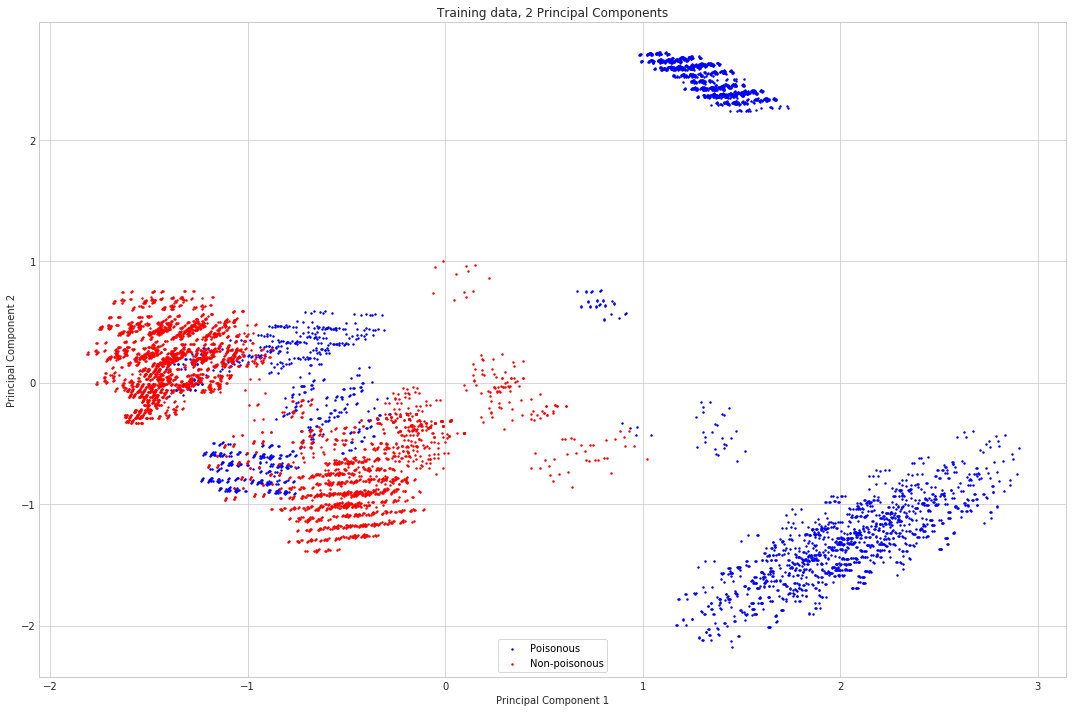

In [7]:
def P2():
    
    #2 component PCA
    pca = PCA(n_components=2)
    PC = pca.fit_transform(train_data)
    
    #add column for poisonous/non poisonous and split into 2 lists for plotting
    PC_labeled = np.append(PC, train_labels[:, None], axis=1)
    PC_poison = PC_labeled[PC_labeled[:,2]==1]
    PC_nonpoison = PC_labeled[PC_labeled[:,2]==0]
    
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(15, 10))
        plt.title('Training data, 2 Principal Components')
        plt.scatter(PC_poison[:,0], 
                    PC_poison[:,1],
                    label = 'Poisonous',
                    c = 'blue', 
                    s = 2) #smaller marker size
        plt.scatter(PC_nonpoison[:,0], 
                    PC_nonpoison[:,1],
                    label = 'Non-poisonous',
                    c = 'red',
                    s = 2)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()


P2()

### Part 3:

Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

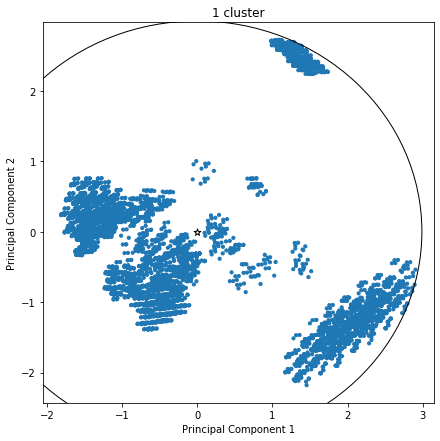

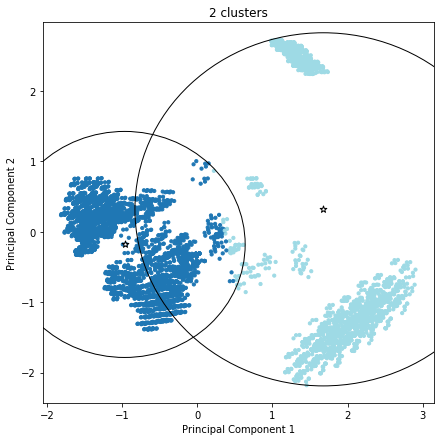

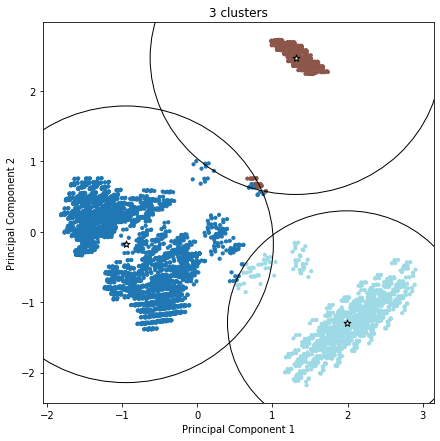

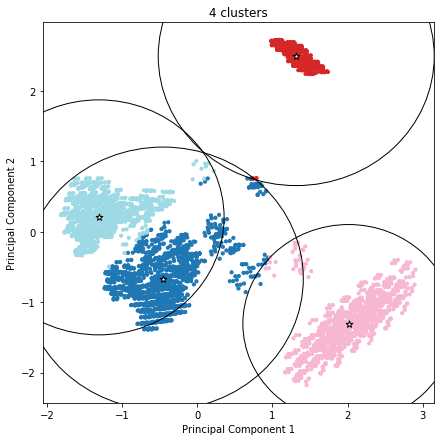

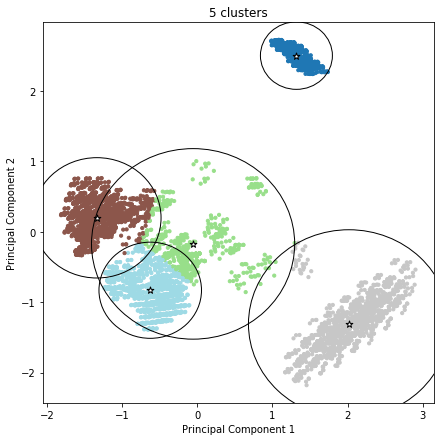

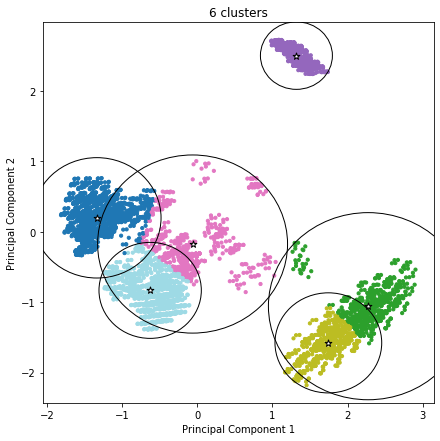

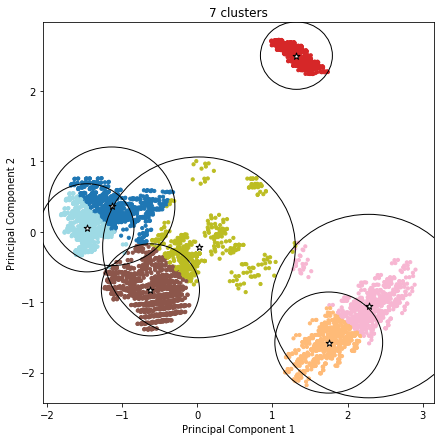

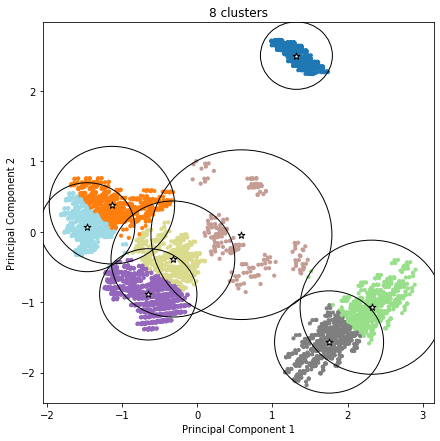

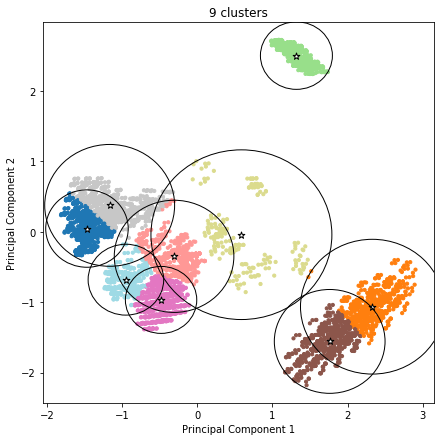

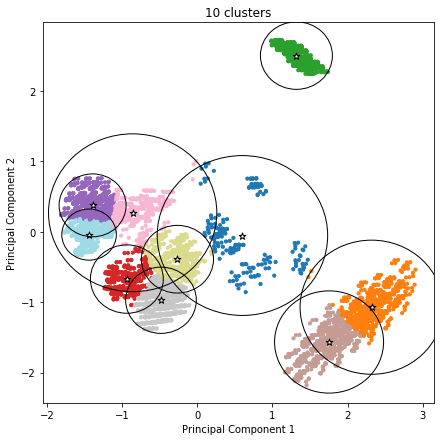

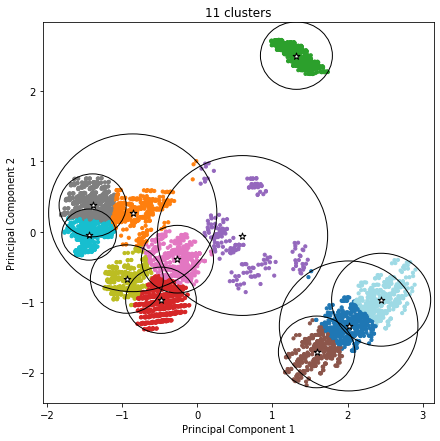

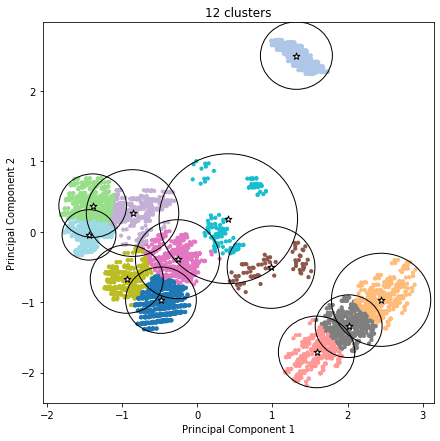

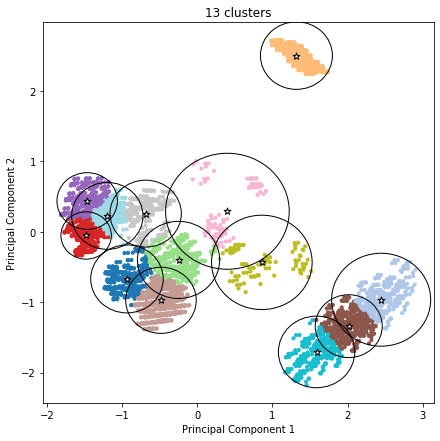

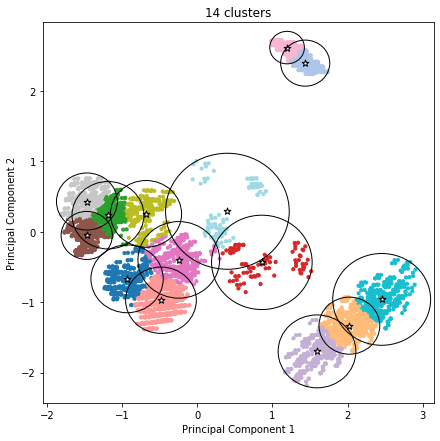

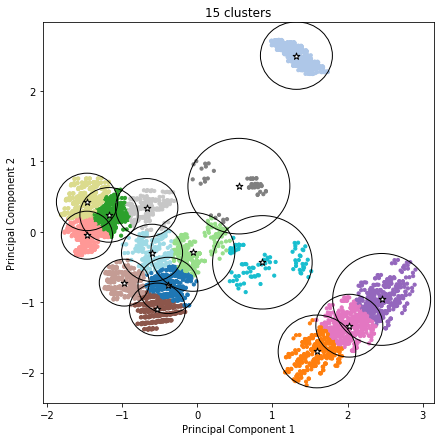

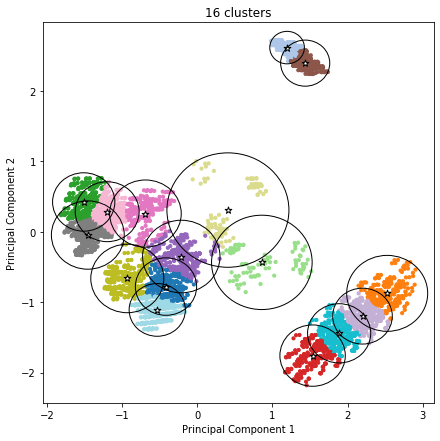

In [8]:
def P3():
    
    #reduce dimensions to 2
    pca = PCA(n_components=2)
    PC = pca.fit_transform(train_data)
    
    #loop through N = 1 to N = 16
    for N in np.arange(1,17):
        
        #Run KM
        km = KMeans(n_clusters = N, n_jobs = -1)
        clstrs = km.fit(PC)
        labels = km.predict(PC)
        
        #get colors from colormap so my colorblind ass doesn't have to manually choose colors
        cmap = plt.cm.get_cmap(name='tab20')
        myColors = cmap(np.linspace(0, 1, N))
        
        #create index to match colors to data points
        myClCols = []
        for ii in np.arange (0, len(clstrs.labels_)):
            color_index = clstrs.labels_[ii]
            myClCols.append(myColors[color_index])

        #create index to match colors to cluster center points
        myCenterCols = []
        for ii in np.arange(0,N):
            color_index = ii
            myCenterCols.append(myColors[color_index])

        #initialize figure
        plt.figure(figsize = (7,7))
        ax = plt.axes()    
        
        #plot data with corresponding colors
        ax.scatter (PC[:,0], PC[:,1], 
                     c = myClCols,
                     #edgecolors = 'k',
                     s = 10) #size of dots
        
        #plot cluster centers. Ended up using white instead of matching colors.
        ax.scatter (clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1], 
                     #c = myCenterCols, 
                     c = 'w', #color = white
                     s = 50, #size of the marker
                     lw = 1, #linewidth
                     edgecolors = 'k', #black edges
                     marker = '*') #star shape marker
            
            
        #plotting circles -- basicaly copied from GMM-amit.ipynb from Week 10
        centers = km.cluster_centers_
        radii = [cdist(PC[labels == i], [center]).max() 
                 for i, center in enumerate(centers)]   #find distance btw center and each data point in cluster, then find max and store as radius 
        for c, r in zip(centers, radii): #plot circles using centers and radii
            ax.add_patch(plt.Circle(c, r,  
                                    fill = False,
                                    lw=1,
                                    ec='k',
                                    alpha=1, 
                                    zorder=1))  
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        if N == 1:
            plt.title (str(N) + " cluster")
        else:
            plt.title (str(N) + " clusters")
        plt.show()
        
P3()

### Part 4:

Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

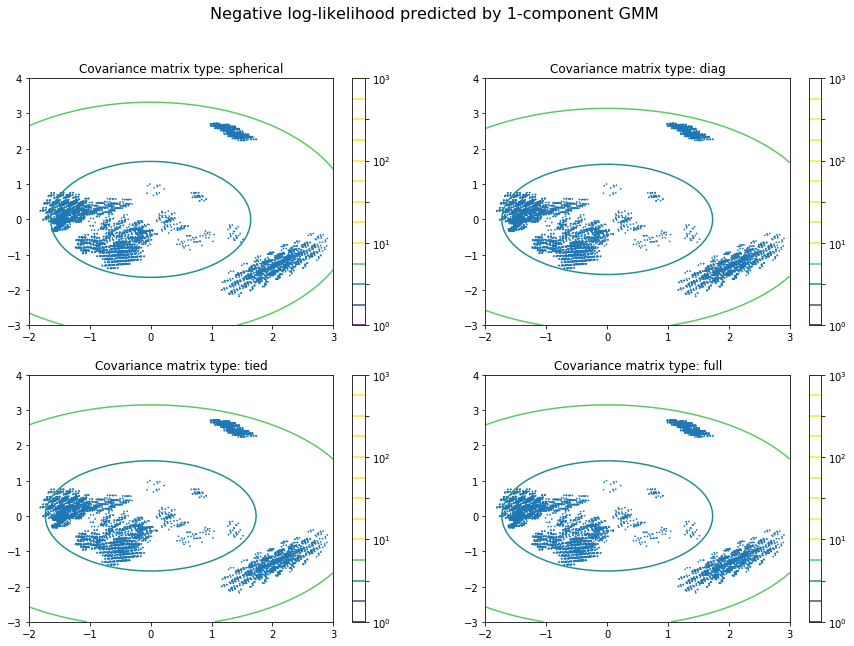

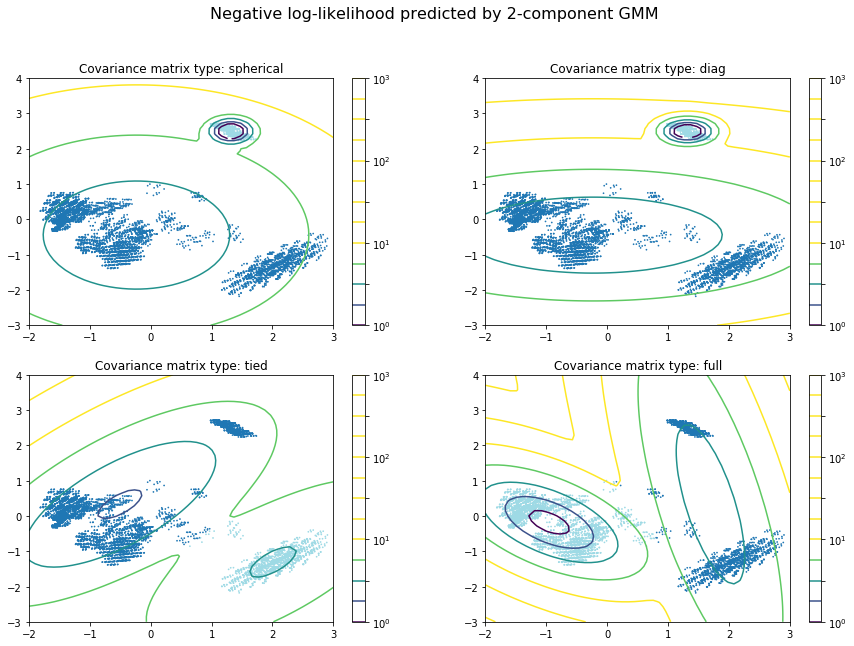

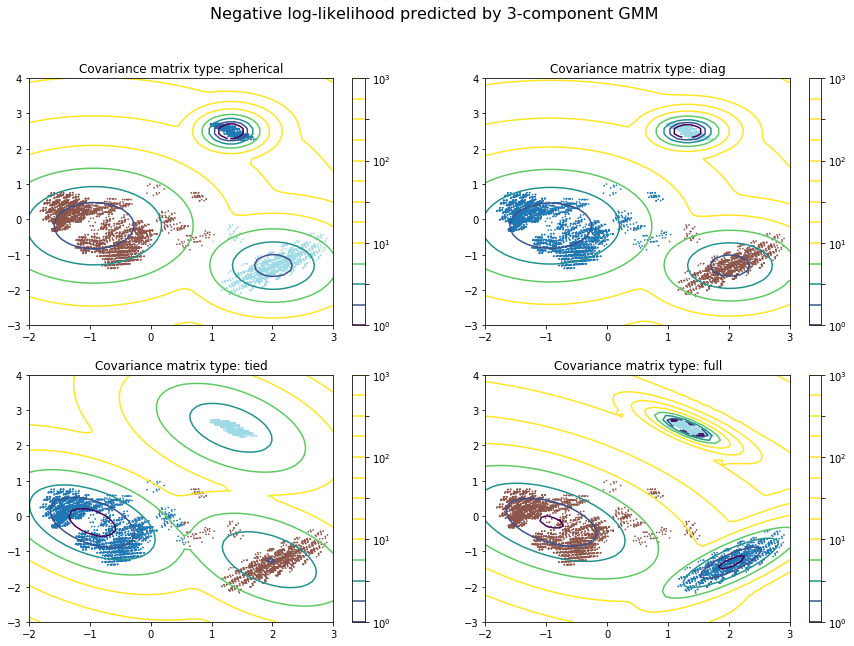

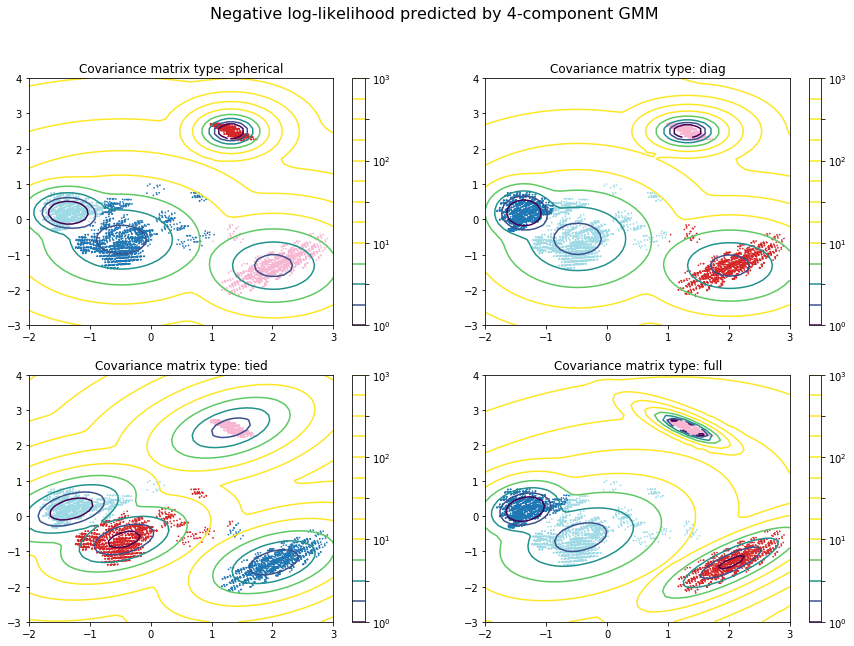

In [9]:
def P4():
    #ignore warnings
    import warnings
    warnings.filterwarnings("ignore")
    
    #reduce dimensions to 2
    pca = PCA(n_components=2)
    PC = pca.fit_transform(train_data)
    
    #parameters we're messing with
    mixture_components = list(range(1 , 4 + 1))
    cm_type = ['spherical', 'diag', 'tied', 'full']
    
    #loop over all combinations of components/covariance types
    k=1
    for mix_comp in mixture_components:
        
        plt.figure(k, figsize = (15,10))
        nn = 1
        
        for cm in cm_type:
            
            #define model
            gmm = GaussianMixture(n_components = mix_comp, covariance_type = cm)
            gmm.fit(PC)
            
            labels = gmm.predict(PC)
            
            plt.subplot(2, 2, nn)
            ax = plt.gca()
            
            # display predicted scores by the model as a contour plot
            x = np.linspace(-2., 3.)
            y = np.linspace(-3., 4.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)

            #plot data with corresponding colors
            ax.scatter (PC[:,0], PC[:,1], 
                         c = labels,
                         cmap='tab20',
                         zorder = 0,
                         #c = myClCols,
                         #edgecolors = 'k',
                         s = 0.5) #size of dots

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=10.0),
                             levels=np.logspace(0, 3, 13), 
                            )

            CB = plt.colorbar(CS, extend='both')

            plt.suptitle('Negative log-likelihood predicted by {0}-component GMM'.format(mix_comp), size = 16)
            plt.title('Covariance matrix type: {0}'.format(cm))
            plt.axis('tight')
            
            
            nn +=1
        plt.show()    
        k +=1

P4()

### Part 5:

Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [10]:
def P5():
    
    #PCA with 2 components
    pca = PCA(n_components=2)
    PC = pca.fit_transform(train_data)
    #transform test data also
    pca_test_data = pca.transform(test_data)
    
    #split into poisonous, nonpoisonous
    PC_pos = PC[train_labels == 1]
    PC_neg = PC[train_labels == 0]
        
    #Defining the 2 models
    gmm_pos = GaussianMixture(n_components = 4, covariance_type = 'full')
    gmm_neg = GaussianMixture(n_components = 4, covariance_type = 'full')
    
    gmm_pos.fit(PC_pos)
    gmm_neg.fit(PC_neg)
    
    #get predicted labels
    pred_labels = []
    for n in pca_test_data:
        #there's no way the scores could be the same right?
        if -gmm_pos.score(n.reshape(1, -1)) == -gmm_neg.score(n.reshape(1, -1)):
            print('wtf')
            break
        #make scores positive; larger score is LESS likely; append 1 for poison, 0 for nonpoison
        elif -gmm_pos.score(n.reshape(1, -1)) > -gmm_neg.score(n.reshape(1, -1)):
            pred_labels.append(0)
        else:
            pred_labels.append(1)
    
    pred_labels = np.array(pred_labels)
    correct = (pred_labels == test_labels)
    correct = np.array(pred_labels == test_labels)
    accuracy = sum(correct)/len(correct)
    print("Accuracy: {0}/{1} correct or {2:.5}".format( sum(correct), len(correct), accuracy))
    
P5()

Accuracy: 1068/1124 correct or 0.95018


Notes: 
1. I am astonished by the accuracy of this model. Actually, I'm uncertain that I did everything correctly because it seems too accurate given looking at the graph in part 1 as well as the fact that our 2-component PCA only explains ~30% of the variance of the training data.
2. If everything is working correctly, there must be a handful of borderline cases. Running the code multiple times gives numbers of correct predicted labels ranging from 1053 to 1068 (as far as I can tell) out of 1124. There are some numbers between 1053 and 1068 that it happens to land on much more frequently than others.

### Part 6:

Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

*Note: This cell takes a couple minutes to run on my laptop*

In [11]:
def P6():
    
    #create function to calculate the combinations of hyperparameters that give us <= 50 parameters total
    def count_parameters():

        #notes
    #     n_cov_full = n_pca * (n_pca + 1)/ 2 * n_gmm
    #     n_cov_diag = n_pca * n_gmm
    #     n_cov_spherical = n_gmm
    #     n_cov_tied = n_pca * (n_pca + 1)/ 2
    #     n_mean = n_pca * n_gmm
    #     parameters = (n_mean + n_cov) * n_classes

        #some values to try
        n_pca = [*range(1, 26, 1)] 
        n_gmm = [*range(1, 26, 1)]
        n_classes = 2

        parameter_count = []
        for pca in n_pca:
            for gmm in n_gmm:
                parameter_count.extend ( ([pca, gmm, (pca*gmm + pca * (pca + 1)/ 2 * gmm) * n_classes, 'full'],
                                        [pca, gmm, (pca*gmm + pca * gmm) * n_classes, 'diag'],
                                        [pca, gmm, (pca*gmm + gmm) * n_classes, 'spherical'],
                                        [pca, gmm, (pca*gmm + pca * (pca + 1)/ 2) * n_classes, 'tied']) ) 
                #[pca, gmm, total, cov type]


        #only include if total count is <=50
        good_parameters = []
        for n in range(0, len(parameter_count)):
            if parameter_count[n][2] <= 50:
                good_parameters.append(parameter_count[n])
    
        return good_parameters
    
    good_parameters = count_parameters()
        
        
    #count_parameters() gives n_pca, n_gmm, and covariance types to try. [pca, gmm, total, cov type]
    
    
    # recycle code from part 5 
    
    #create list to store model parameters, accuracy
    models_acc = []
    
    
    for n in range(0, len(good_parameters)):
        
        #Run PCA with nth parameter
        pca = PCA(n_components = good_parameters[n][0])
        PC = pca.fit_transform(train_data)
        pca_test_data = pca.transform(test_data)
        
        #split into poisonous, nonpoisonous
        PC_pos = PC[train_labels == 1]
        PC_neg = PC[train_labels == 0]
        
        #define our GMMs with nth parameters
        gmm_pos = GaussianMixture(n_components = good_parameters[n][1], covariance_type = good_parameters[n][3])
        gmm_neg = GaussianMixture(n_components = good_parameters[n][1], covariance_type = good_parameters[n][3])
        
        #fit the 2 models
        gmm_pos.fit(PC_pos)
        gmm_neg.fit(PC_neg)
        
        #get predictions
        pred_labels = []
        for ii in pca_test_data:
            #there's no way two scores could be the same, right?
            if -gmm_pos.score(ii.reshape(1, -1)) == -gmm_neg.score(ii.reshape(1, -1)):
                print('wtf')
                pred_labels.append('na')
            #make scores positive; larger score is LESS likely; append 1 for poison, 0 for nonpoison
            elif -gmm_pos.score(ii.reshape(1, -1)) > -gmm_neg.score(ii.reshape(1, -1)):
                pred_labels.append(0)
            else:
                pred_labels.append(1)

        pred_labels = np.array(pred_labels)
        correct = (pred_labels == test_labels)
        correct = np.array(pred_labels == test_labels)
        accuracy = sum(correct)/len(correct)
        
        #save the accuracies and parameters of each model
        models_acc.append([sum(correct),
                            len(correct), 
                            accuracy, 
                            good_parameters[n][0],
                            good_parameters[n][1],
                            good_parameters[n][3]])
        
    #define a sorting function for sorting by accuracy
    def sort_acc(acc): 
        #sorts list of lists by third element, descending
        return(sorted(acc, key = lambda x: x[2], reverse = True))     
    
    #sort by accuracy, print 10 best models
    models_acc = sort_acc(models_acc)
    print("Best model:")
    print("Accuracy: {0}/{1} correct or {2:.5} with n_PCA = {3}, n_GMM = {4}, cov_type = {5}".format(
                    models_acc[0][0], 
                    models_acc[0][1], 
                    models_acc[0][2], 
                    models_acc[0][3], 
                    models_acc[0][4], 
                    models_acc[0][5]))
    print("\nOther top models:")
    for x in range(1,10):
        print("Accuracy: {0}/{1} correct or {2:7.5} with n_PCA = {3}, n_GMM = {4}, cov_type = {5}".format(
                    models_acc[x][0], 
                    models_acc[x][1], 
                    models_acc[x][2], 
                    models_acc[x][3], 
                    models_acc[x][4], 
                    models_acc[x][5]))
    
P6()

Best model:
Accuracy: 1094/1124 correct or 0.97331 with n_PCA = 7, n_GMM = 3, cov_type = spherical

Other top models:
Accuracy: 1090/1124 correct or 0.96975 with n_PCA = 4, n_GMM = 3, cov_type = tied
Accuracy: 1088/1124 correct or 0.96797 with n_PCA = 5, n_GMM = 4, cov_type = spherical
Accuracy: 1088/1124 correct or 0.96797 with n_PCA = 6, n_GMM = 3, cov_type = spherical
Accuracy: 1086/1124 correct or 0.96619 with n_PCA = 5, n_GMM = 3, cov_type = spherical
Accuracy: 1083/1124 correct or 0.96352 with n_PCA = 3, n_GMM = 5, cov_type = spherical
Accuracy: 1078/1124 correct or 0.95907 with n_PCA = 2, n_GMM = 5, cov_type = full
Accuracy: 1078/1124 correct or 0.95907 with n_PCA = 5, n_GMM = 2, cov_type = tied
Accuracy: 1076/1124 correct or  0.9573 with n_PCA = 4, n_GMM = 5, cov_type = spherical
Accuracy: 1075/1124 correct or 0.95641 with n_PCA = 2, n_GMM = 10, cov_type = tied
